# Scrap, clean and explore Flight prices


Cost of flight tickets is one of the biggest and a variable cost on most trips. Thus optimizing on flight ticket costs can tremendously reduce the cost of a vacation.

Flight prices vary by many factors like airports, time of travel, the number of stops, airlines, the day of week ticket is purchased, how many days in advance the ticket is booked, travel website used, remaining seats on the flight, number adults on the ticket, browsing history, etc. With so many variables, it makes for a perfect case to apply machine learning in finding the seasonal trends in flight prices. Unfortunately, the airline and travel industry is opaque and keeps this data very well hidden. I was not able the data required to forecast the air ticket price. 

But all is not lost. Many search engines do a great job providing the best flight deals on a particular set of future travel dates. So I could scrap the flight price data from [Matrix - ITA Software by Google](https://matrix.itasoftware.com/) over a range of future travel dates to find the best time to fly. The con of this approach is that I don't know if I could have saved money if I had booked the flight earlier or later, or the day of the week when I bought the ticket. In my analysis, since I am going to book flight tickets well in advance, I will assume that these factors will have a negligible influence on the price of the flight ticket. 

In [1]:
import urllib.request
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Flight search details

In my analysis I sraped for the best flight prices for travel start dates ranging from 1st December 2018 to 30th April 2019 for a travel stay of 4 nights. 

My original plan was to use Python Mechanize to browse the Matrix - ITA software website to get the flight prices. However, due to robot restrictions, this turned out to be more work than worth the hassle. Since, ITA software provided calendar view for a months travel date, in few clicks I could save webpages locally for all the winter travel dates. So that is what I did. 

I searched for flight prices on Tuesday night, to get optimize on price saving. Many articles say that buying flights on Tuesday is cheaper. 

### Source airport

From Madison, WI, I can possibly fly from airports in three different region: 
1. Madison: The closest airport
2. Chicago: Will have more flight options, but it is 2-3 hours away by bus. The bus tickets will have additional cost. 
3. Milwaukee: Will have more flight options and is about an hour away by bus. Will need to account for additional bus ticket cost. 

The destination airports remains Denver International, CO, for all the comparison. 

Here I provide the local storage where I save all the flight price webpages for each source airports.

In [2]:
flight_source = {}
flight_source['Madison'] = 'file:///home/mohak/Data/VacationPlanner/madison/'
flight_source['Chicago'] = 'file:///home/mohak/Data/VacationPlanner/chicago/'
flight_source['Milwaukee'] = 'file:///home/mohak/Data/VacationPlanner/milwaukee/'

### BeautifulSoup to extract data from html pages

Using Python BeautifulSoup, I find the flight prices for a given date in locally saved webpages and save these details into a pandas dataframe.

In [3]:
def scrap_flightprice_source(url_prefix):
    
    # months for which I saved flight prices in calendar view
    months = ['dec', 'jan', 'feb', 'mar', 'apr']
    year = ['2018-12-', '2019-1-', '2019-2-', '2019-3-', '2019-4-']
    year = dict(zip(months, year))
    date, price = [], []

    for month in months:

        url_path = url_prefix + month + '.html'
        page = urllib.request.urlopen(url_path)
        soup = BeautifulSoup(page, 'html.parser')
        
        # Extract date and price in each month
        date_box = soup.find_all('div', attrs={'class': 'IR6M2QD-c-d'})
        price_box = soup.find_all('div', attrs={'class': 'IR6M2QD-c-a'})
        price_box.extend(soup.find_all('div', attrs={'class': 'IR6M2QD-c-s'}))
        
        # Save date and price data in a list
        for date_text, price_text in zip(date_box, price_box[:-1]):
            date.append(year[month] + date_text.text)
            price.append(float(price_text.text[1:]))
    
    # Save it as dataframe and crop the dates of travel
    d = {'date':date, 'price':price}
    df = pd.DataFrame(d)
    df['date'] = pd.to_datetime(df['date'], yearfirst=True)
    df = df[(df['date'] >= '2018-12-15') & (df['date'] <= '2019-04-15')]
        
    return df

# Combine flight prices from different sources in a single df
df = scrap_flightprice_source(flight_source['Madison'])
df['Chicago'] = scrap_flightprice_source(flight_source['Chicago'])['price']
df['Milwaukee'] = scrap_flightprice_source(flight_source['Milwaukee'])['price']
df = df.rename(index=str, columns={'price':'Madison'})
df.head(10)

,date,Madison,Chicago,Milwaukee
14,2018-12-15,261.0,202.0,287.0
15,2018-12-16,267.0,237.0,351.0
16,2018-12-17,415.0,230.0,347.0
17,2018-12-18,261.0,257.0,474.0
18,2018-12-19,381.0,212.0,411.0
19,2018-12-20,409.0,202.0,351.0
20,2018-12-21,321.0,210.0,381.0
21,2018-12-22,469.0,262.0,342.0
22,2018-12-23,381.0,242.0,493.0
23,2018-12-24,381.0,222.0,407.0


### Bus and inconvenience cost

To fly from Chicago or Milwaukee, I will need to add the price of round trip bus tickets in the cost analysis. 

In [4]:
df['Chicago'] = df['Chicago'] + 60 + 15 # Bus: 60, inconvenice: 15
df['Milwaukee'] = df['Milwaukee'] + 46 +10 # Bus: 46, inconvenice: 10

### Visualize

Look at the trends in flight price and narrow down best time to fly. We can see that prices from Milwaukee are not the cheapest for any dates, so we drop it and visualize the plot again to reduce the clutter

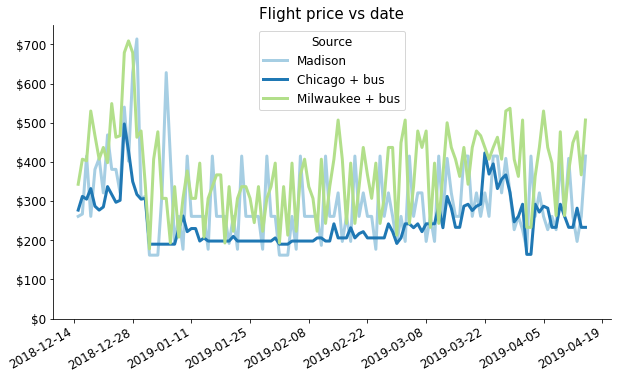

In [5]:
fig = plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 12})
plt.plot(df['date'], df['Madison'], color='#a6cee3', label='Madison', linewidth=3)
plt.plot(df['date'], df['Chicago'], color='#1f78b4', label='Chicago + bus', linewidth=3)
plt.plot(df['date'], df['Milwaukee'], color='#b2df8a', label='Milwaukee + bus', linewidth=3)

plt.legend(title='Source', fontsize=12)
plt.ylim(0,750)

ax = fig.axes
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_yticklabels(['${0:0.0f}'.format(x) for x in ax[0].get_yticks()])
fig.autofmt_xdate()
ax[0].set_title('Flight price vs date', fontsize=15);

### Replot clean visualization

We replot the prices only for Madison and Chicago

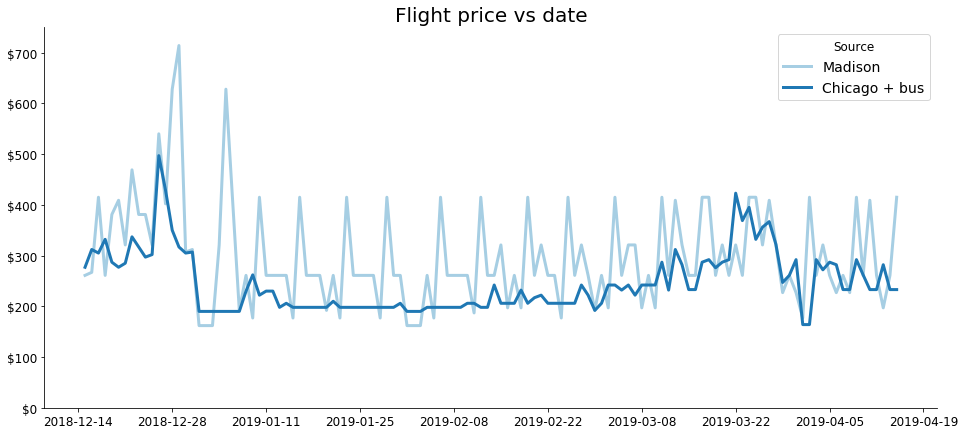

In [6]:
fig = plt.figure(figsize=(16,7))
plt.rcParams.update({'font.size': 12})
plt.plot(df['date'], df['Madison'], color='#a6cee3', label='Madison', linewidth=3)
plt.plot(df['date'], df['Chicago'], color='#1f78b4', label='Chicago + bus', linewidth=3)

plt.legend(title='Source', fontsize=14)
plt.ylim(0,750)

ax = fig.axes
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_yticklabels(['${0:0.0f}'.format(x) for x in ax[0].get_yticks()])
ax[0].set_title('Flight price vs date', fontsize=20);

### Save cleaned data

We drop the column for Milwaukee and save the data for further analysis. 

In [7]:
df = df.drop(columns='Milwaukee')
df.to_csv('../../Data/VacationPlanner/flight_price.csv')